In [1]:
import os
import json
import numpy as np
import heapq
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

In [2]:
# 실질적으로 있는 노선 찾기
def notion_filter(df_notion, bus_card_sorted):
    notion_list = []
    for route_number, route_group in df_notion.groupby('노선번호'):
        
        for i, j in bus_card_sorted.groupby('card_rout_cd'):
            if route_group.iloc[0]['노선ID'] == i:
                notion_list.append(i)
                break
    return notion_list

In [3]:
def to_seconds(time_val):
    if pd.isnull(time_val): return None
    
    # 숫자를 문자열로 변환하고 길이에 따라 처리
    time_val = str(int(time_val)).zfill(6)  # 최소 6자리로 채움, 예: 011101 -> 00시11분01초
    
    if len(time_val) == 4:  # 4자리 (HHMM)
        hh, mm = int(time_val[:2]), int(time_val[2:])
        ss = 0  # 초는 0으로 설정
    elif len(time_val) == 6:  # 6자리 (HHMMSS)
        hh, mm, ss = int(time_val[:2]), int(time_val[2:4]), int(time_val[4:])
    
    return hh * 3600 + mm * 60 + ss

In [8]:
def create_time_table(bus_card_info_path, bus_stop_info_path, notion_info_path, notion_to_bus_stop_path):
    
    bus_card_info_df = pd.read_csv(bus_card_info_path) # 버스카드거래 정보 (세종시_버스카드거래이력_2025-04-02)
    bus_stop_info_df = pd.read_csv(bus_stop_info_path, encoding='euc-kr') # 버스 정류장 정보 (세종특별자치시_정류장정보_20241125)
    notion_info_df = pd.read_csv(notion_info_path, encoding='euc-kr') # 버스 노선 정보 (세종특별자치시_노선정보_20241125)
    notion_to_bus_stop_df = pd.read_csv(notion_to_bus_stop_path, encoding='euc-kr') # 노선 별 정류장 현황 (세종특별자치시_노선별 정류장현황_20241125)

    id_to_name = notion_info_df.set_index('노선번호')['노선ID'].to_dict()
    id_to_name2 = notion_info_df.set_index('노선ID')['노선명'].to_dict()
    notion_to_bus_stop_df['노선ID'] = notion_to_bus_stop_df['노선번호'].map(id_to_name)

    route_station_order = notion_to_bus_stop_df.sort_values(by=['노선ID', '정류장순서']) \
                    .groupby('노선ID')['정류장ID'] \
                    .apply(list) \
                    .reset_index(name='정류장ID_순서')

    bus_card_info_df['승차정류장ID'] = bus_card_info_df['card_brd_sttn_id']
    bus_card_info_df['하차정류장ID'] = bus_card_info_df['card_alit_sttn_id']

    id_to_name3 = bus_stop_info_df.set_index('정류장ID')['버스정류장명'].to_dict()

    bus_card_info_df['승차버스정류장명'] = bus_card_info_df['승차정류장ID'].map(id_to_name3)
    bus_card_info_df['하차버스정류장명'] = bus_card_info_df['하차정류장ID'].map(id_to_name3)


    test = bus_card_info_df


    # 시간 계산
    test['탑승초'] = test['card_brd_tm'].apply(to_seconds)
    test['하차초'] = test['alit_deal_tm'].apply(to_seconds)

    # 날짜 차이 계산 (같은 날이면 0, 다음 날이면 +1일 고려)
    test['탑승일'] = pd.to_datetime(test['brd_deal_dt'], format='%Y%m%d', errors='coerce')
    test['하차일'] = pd.to_datetime(test['alit_deal_dt'], format='%Y%m%d', errors='coerce')

    # 전체 초 계산
    test['탑승총초'] = test['탑승일'].astype('int64') // 10**9 + test['탑승초']
    test['하차총초'] = test['하차일'].astype('int64') // 10**9 + test['하차초']

    # 소요 시간 계산
    test['소요시간(초)'] = test['하차총초'] - test['탑승총초']
    bus_card_sorted = test.sort_values(by=['탑승일', '탑승초']).reset_index(drop=True)

    notion_list = notion_filter(notion_to_bus_stop_df, bus_card_sorted)
    filtered_routes = route_station_order[route_station_order['노선ID'].isin(notion_list)]

    avg_times = []


    id_to_route_number = {v: k for k, v in id_to_name.items()}
    # filtered_routes에서 각 노선별로 정류장ID_순서를 순차적으로 처리
    for _, row in filtered_routes.iterrows():
        route_id = row['노선ID']  # 노선번호
        route_stops = row['정류장ID_순서']  # 정류장ID_순서 리스트
        
        # 정류장 순서대로 구간을 나누어 평균 소요시간 계산
        for i in range(len(route_stops) - 1):
            start = route_stops[i]
            goal = route_stops[i + 1]
            
            # 출발정류장과 도착정류장에 대한 데이터를 필터링
            df_segment = test[
                (
                    ((test['승차정류장ID'] == start) & (test['하차정류장ID'] == goal)) |
                    ((test['승차정류장ID'] == goal) & (test['하차정류장ID'] == start))
                ) &
                (test['card_rout_cd'] == route_id)
            ]

            
            if not df_segment.empty:
                avg_time_min = df_segment['소요시간(초)'].mean() / 60  # 초 -> 분 변환
                most_common_stop = df_segment['하차버스정류장명'].mode().iloc[0] if not df_segment['하차버스정류장명'].mode().empty else ''
                most_common_stop2 = df_segment['승차버스정류장명'].mode().iloc[0] if not df_segment['승차버스정류장명'].mode().empty else ''
                avg_times.append({
                    '출발정류장ID': start,
                    '출발정류장명': id_to_name3.get(start),
                    '도착정류장ID': goal,
                    '도착정류장명': id_to_name3.get(goal),
                    '평균소요시간(분)': round(avg_time_min, 2),
                    '노선ID': route_id,
                    '노선번호': f"{id_to_route_number.get(route_id)}({most_common_stop})",
                    '노선번호2': f"{id_to_route_number.get(route_id)}({most_common_stop2})",
                    '노선번호임시': id_to_name2.get(route_id),
                })

    # 결과 출력
    avg_times_df = pd.DataFrame(avg_times)
    return avg_times_df, notion_list

In [18]:
# (A) 그래프 생성
def create_bus_graph(stop_csv_path, line_stop_csv_path, notion_info_path, result_df, notion_list):
    """
    1) stop_csv_path 에서 정류장 정보 읽어 노드 생성
       - 노드는 정류장ID를 키로, 속성: station_name, x, y
    2) line_stop_csv_path 에서 노선별 정류장 순서를 읽어,
       순방향 + 역방향(왕복) 엣지를 추가.
       - 엣지 속성으로 route_name, route_number, weight 등을 저장
    3) A* 데모를 위해:
       - stations: 정류장ID 리스트
       - edges: [(u, v, w, route_name), ...] 형태로 모두 수집
       - heuristic_table: 임시로 (정류장ID -> 랜덤값) 혹은 0 으로 설정
    4) return: G, stations, edges, heuristic_table
    """

    stop_df = pd.read_csv(stop_csv_path, encoding='cp949')
    line_stop_df = pd.read_csv(line_stop_csv_path, encoding='cp949')
    notion_info_df = pd.read_csv(notion_info_path, encoding='euc-kr')
    num_to_id = notion_info_df.set_index('노선번호')['노선ID'].to_dict()
    line_stop_df['노선ID'] = line_stop_df['노선번호'].map(num_to_id)
    filtered_routes = line_stop_df[line_stop_df['노선ID'].isin(notion_list)]
    
    G = nx.DiGraph()
    station_name_to_id = {}

    # (1) 노드 생성
    for i, row in stop_df.iterrows():
        station_id = row['정류장ID']
        station_name = row['버스정류장명']
        x_coord = row['정류장 X좌표']
        y_coord = row['정류장 Y좌표']

        G.add_node(
            station_id,
            station_name=station_name,
            x=x_coord,
            y=y_coord
        )
        # 매핑 사전 저장 (정류장명 -> 정류장ID)
        station_name_to_id[station_name] = station_id

    # (2) 엣지 생성 (왕복 처리)
    edges = []
    for route_number, route_group in filtered_routes.groupby('노선번호'):
        route_group_sorted = route_group.sort_values('정류장순서')


        
        route_id = route_group_sorted.iloc[0]['노선ID']
        time_table = result_df[result_df['노선ID'] == route_id]
        for i in range(len(route_group_sorted) - 1):
            from_stop = route_group_sorted.iloc[i]['정류장ID']
            to_stop   = route_group_sorted.iloc[i + 1]['정류장ID']
            df_segment = time_table[
                (time_table['출발정류장ID'] == from_stop) &
                (time_table['도착정류장ID'] == to_stop)
            ]
            route_name_1 = time_table['노선번호']
            route_name_2 = time_table['노선번호']

            if not df_segment.empty:
                weight = df_segment['평균소요시간(분)']
            else:
                weight = time_table['평균소요시간(분)'].mean()
            if time_table.empty:
                weight = result_df['평균소요시간(분)'].mean()
            # 순방향
            G.add_edge(
                int(from_stop), int(to_stop),
                route_number=route_number,
                route_name=route_name_1,
                weight=int(weight)  # 실제론 거리 or 시간
            )
            edges.append((from_stop, to_stop, 1, route_name_1))

            # 역방향(왕복)
            G.add_edge(
                int(to_stop), int(from_stop),
                route_number=route_number,
                route_name=route_name_2,
                weight=int(weight)
            )
            edges.append((to_stop, from_stop, 1, route_name_2))

    # (3) stations 리스트
    stations = list(G.nodes())

    # (4) 휴리스틱 테이블 (A*용)
    heuristic_table = {station: np.random.randint(0, 10) for station in stations}

    return G, stations, edges, heuristic_table

In [19]:
####################################
# (B) 시각화 함수
####################################
def plot_bus_graph(G, path=None, start=None, goal=None,
                   checking_edges=None, weight_tag=True,
                   route_tag=False, node_size=50,
                   title="Bus Routes Graph"):
    """
    - path: A* 결과 (정류장ID list)
    - start, goal: 노드(정류장ID)
    - checking_edges: 탐색 중 확인한 엣지
    - weight_tag: True면 edge weight 표시
    - route_tag: True면 edge에 노선명(route_name) 표시
    - node_size: 노드 크기 
    """

    # (1) 노드 위치를 (x, y) 좌표로 지정
    pos = {}
    for n in G.nodes():
        x_coord = G.nodes[n].get('x', 0.0)
        y_coord = G.nodes[n].get('y', 0.0)
        pos[n] = (x_coord, y_coord)

    # (2) 그림 크기, 축 등
    plt.figure(figsize=(20, 16))

    # (3) 전체 엣지
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        alpha=0.5,
        arrows=True,
        connectionstyle='arc3,rad=0.05'
    )

    # (4) path 강조
    if path:
        path_edges = list(zip(path, path[1:]))

        # 탐색 중 확인한 엣지 (주황색)
        if checking_edges:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=checking_edges,
                edge_color='orange',
                alpha=0.4,
                width=3,
                arrows=True,
                connectionstyle='arc3,rad=0.05'
            )
        # 최종 경로 (빨간색)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='red',
            width=5,
            arrows=True,
            connectionstyle='arc3,rad=0.05'
        )

    # (5) 노드 표시
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color='lightblue'
    )

    # (6) 엣지 라벨
    if weight_tag:
        edge_labels = {
            (u, v): G[u][v].get('weight', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='green'
        )
    elif route_tag:
        edge_labels = {
            (u, v): G[u][v].get('route_name', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='blue'
        )


    if path and start and goal:
        title = f"{title}\nStart: {start}, Goal: {goal}"

    plt.title(title, fontsize=13)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
bus_card_info_path = "data/bus.csv"                                          # 버스카드거래 정보 (세종시_버스카드거래이력_2025-04-02)
bus_stop_info_path = "data/a.csv"                                            # 버스 정류장 정보 (세종특별자치시_정류장정보_20241125)
notion_info_path = "data/세종특별자치시_노선정보_20241125.csv"                 # 버스 노선 정보 (세종특별자치시_노선정보_20241125)
notion_to_bus_stop_path = "data/세종특별자치시_노선별 정류장현황_20241125.csv" # 노선 별 정류장 현황 (세종특별자치시_노선별 정류장현황_20241125)


result_df, notion_list = create_time_table(bus_card_info_path, bus_stop_info_path, notion_info_path, notion_to_bus_stop_path)

In [ ]:
stop_csv_path = "data/세종특별자치시_정류장정보_20241125.csv"       # 예: "정류장ID, 버스정류장명, 정류장 X좌표, 정류장 Y좌표" 등 포함
line_stop_csv_path = "data/세종특별자치시_노선별 정류장현황_20241125.csv"  # 예: "노선번호, 노선명, 정류장ID, 정류장순서" 등 포함
bus_card_csv_path = "data/bus.csv" # 버스 카드 정보

 
# 그래프 생성
G, stations, edges, heuristic_table = create_bus_graph(
    stop_csv_path,
    line_stop_csv_path,
    notion_info_path,
    result_df,
    notion_list
)

/tmp/ipykernel_21168/1147899641.py:72: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  weight=int(weight)  # 실제론 거리 or 시간
/tmp/ipykernel_21168/1147899641.py:81: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  weight=int(weight)


In [23]:
graph_json = json_graph.node_link_data(G)

In [24]:
#save graph as json
graph_json = json_graph.node_link_data(G)
with open("graphs/sejong_bus.json", "w") as json_file:
    json.dump(graph_json, json_file)

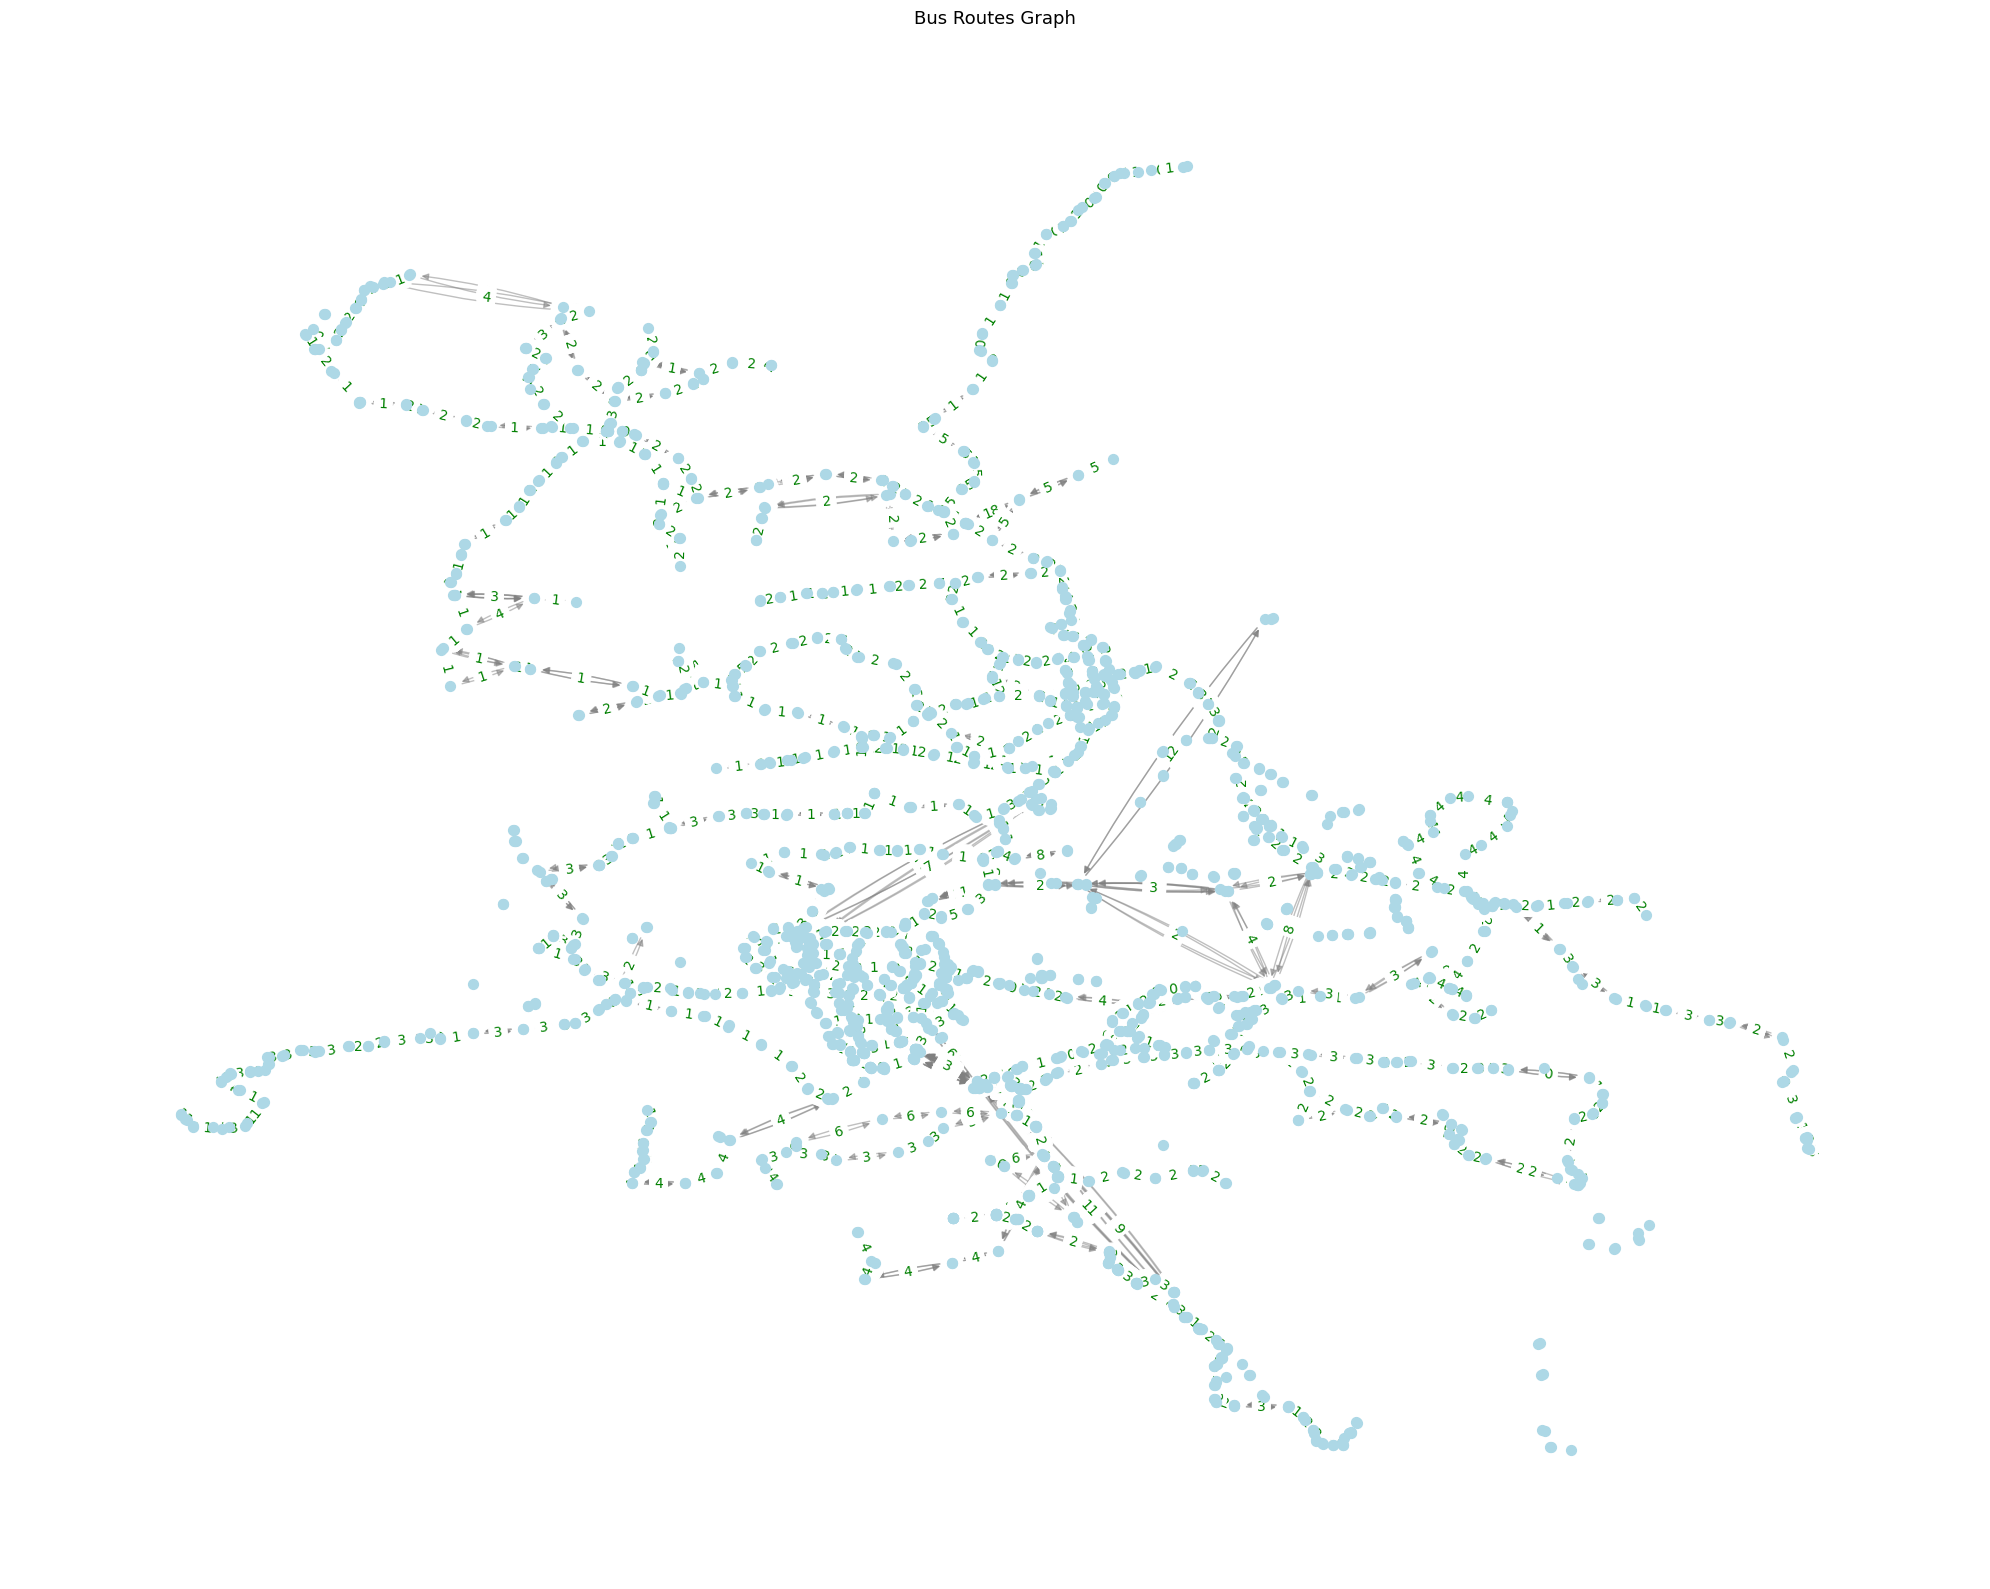

In [23]:
plot_bus_graph(G)

In [135]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


In [136]:
# A* 시연
if len(stations) >= 2:
    start = stations[30]            
    goal = stations[100]           
    path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)

    print("Count       :", count)
    print("Cost        :", cost)
    print("# of Checking edges:", len(checking_edges))
    print("Path        :", path)
else:
    start, goal, path, cost, count, checking_edges = None, None, None, None, None, None

Count       : 1710
Cost        : 28
# of Checking edges: 813
Path        : [6800031, 6806274, 6800947, 6800948, 6806361, 6806358, 6801241, 6800319, 6800862, 6800113, 6800112, 6800974, 6806239, 6800315, 6800109]


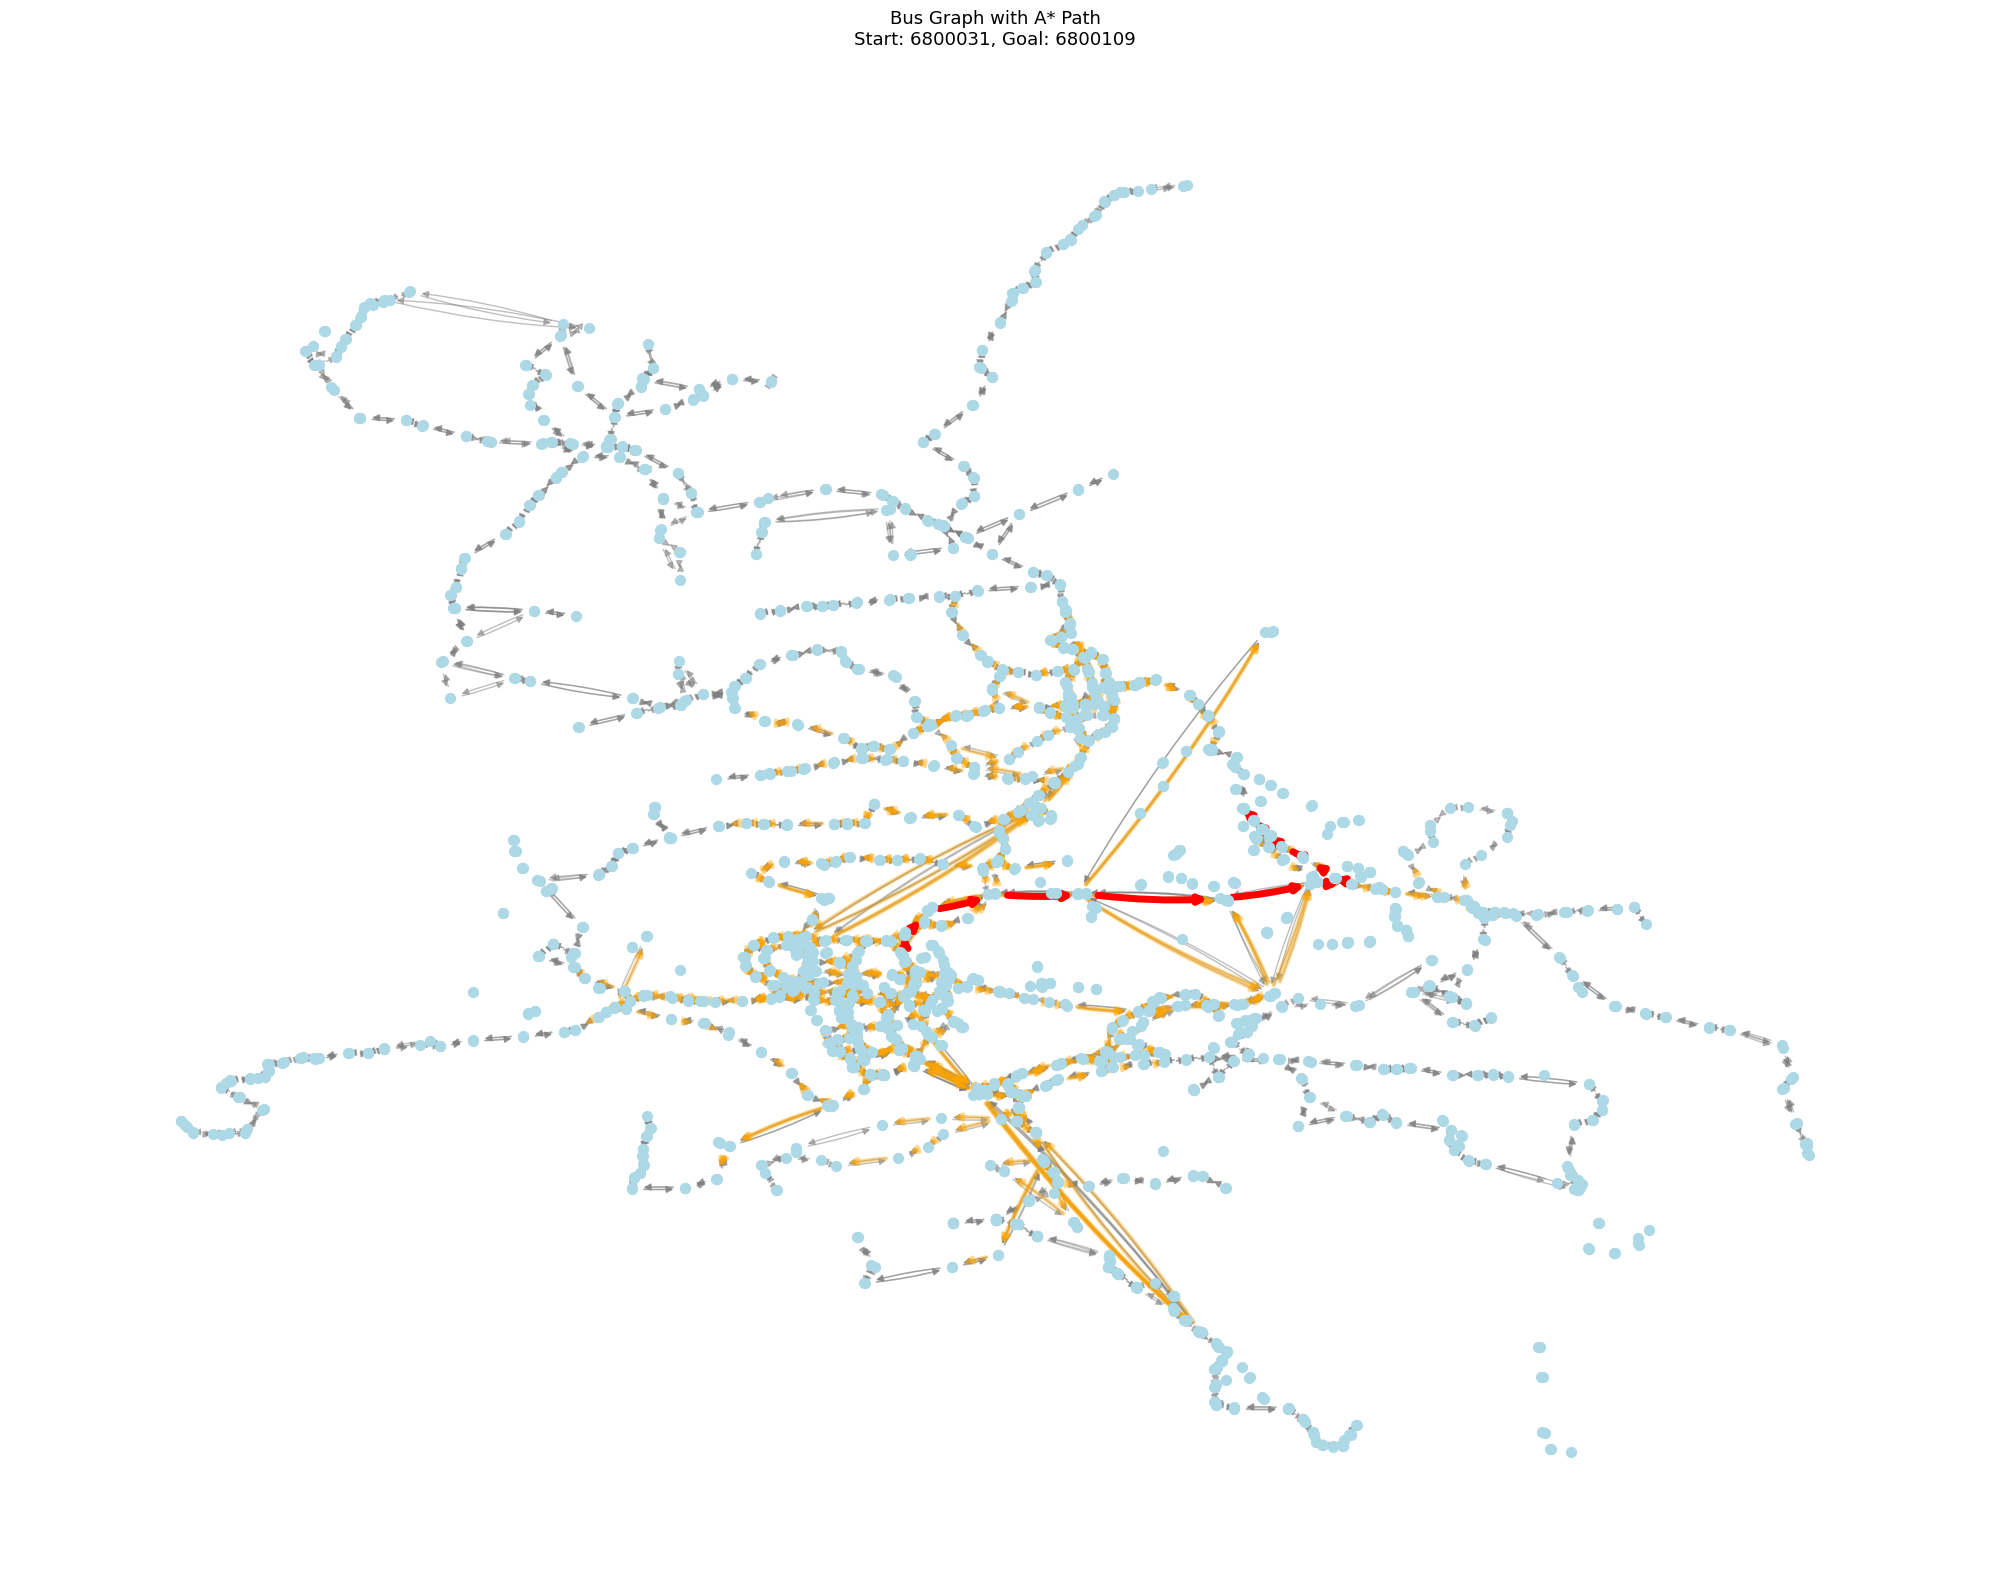

In [137]:
# 최단경로 시각화
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title="Bus Graph with A* Path"
)

In [ ]:
# 방향성 고려해서 수정하기